In [5]:
%run '../definitions.ipynb'

In [6]:
import os
import pandas as pd
from tqdm import tqdm
import zipfile
import zlib
import os
import gc

class XAMSRaw():
    __version__ = '0.1.1'
    base_dir = ''
    filenames = []
    d = None
    channels = [0, 1]
    
    ###################### Initialization and data loading
    
    def __init__(self, data_dir, run_name, pickle_dir = '/home/erik/win/data/xams_run8/single_e_waveforms/'):
        self.run_name = run_name
        self.base_dir = os.path.join(data_dir, run_name)
        self.pickle_dir = os.path.join(pickle_dir, run_name)
        self.filenames = os.listdir(self.base_dir)
        self.filenames = [_f for _f in self.filenames if _f[-4:] == '.zip']
        self.d = pd.DataFrame()
        
        if not os.path.exists(self.pickle_dir):
            print('Making new pickle directory')
            os.makedirs(self.pickle_dir)
        
        return
    
    def load_one(self, number=0):
        file_path = os.path.join(self.base_dir, self.filenames[number])
        pulse_list_0, pulse_list_1 = self._read_pulses_in_file(file_path)
        self.d['pulse_0'] = pulse_list_0
        self.d['pulse_1'] = pulse_list_1
        return
    
    def load_all(self, stop_after = np.inf, from_pickle = True, to_pickle = True, verbose = False):
        # Check if we already have data, if so, throw it out
        if len(self.d) > 0:
            print('You already loaded data, I will remove that now!')
            self.d = pd.DataFrame()
        
        # Lists to contain all pulses for both channels
        pulse_list_0 = []
        pulse_list_1 = []
        
        # Loop over .zip files
        for filename in tqdm(self.filenames[:stop_after]):
            
            file_path = os.path.join(self.base_dir, filename)
            # Get filename and full path to pickle
            pickle_filename = filename.replace('.zip', '_waveforms.pickle')
            pickle_path = os.path.join(self.pickle_dir, pickle_filename)
            if from_pickle:
                # Check if we have a correspoding pickle file
                if os.path.isfile(pickle_path):
                    _pulse_list_0, _pulse_list_1 = pickle.load(open(pickle_path, 'rb'))
                else:
                    _pulse_list_0, _pulse_list_1 = self._read_pulses_in_file(file_path)
            else:
                _pulse_list_0, _pulse_list_1 = self._read_pulses_in_file(file_path)
            pulse_list_0 = pulse_list_0 + _pulse_list_0
            pulse_list_1 = pulse_list_1 + _pulse_list_1
            
            if to_pickle and not os.path.isfile(pickle_path):
                pickle.dump((_pulse_list_0, _pulse_list_1), open(pickle_path, 'wb'))
            
        self.d['pulse_0'] = pulse_list_0
        self.d['pulse_1'] = pulse_list_1
        print('Read %d events' % len(self.d))
        return
        
    def remove_channel(self, channel):
        '''
        Throws out all the information of one channel
        '''
        for key in self.d.keys():
            if int(key.split(sep='_')[-1]) == channel:
                del self.d[key]
        self.channels = [_channel for _channel in self.channels if _channel is not channel]
        return
            
    ###################### Basic processing
    # All `compute_` functions add one or more variable to the dataframe
    # All `correct_` functions will change the waveform (and also the `invert` one, incidentally)
    
    
    def compute_baselines(self, baseline_bounds = (0, 300), mode='average'):
        '''
        Compute the baseline by using the waveform within a certain range.
        Modes enabled: `average`.
        '''
        for channel in self.channels:
            self.d['baseline_%d' % channel] = self._get_baseline(channel, baseline_bounds, mode)
        return
        
    def compute_baselines_double(self, baseline_bounds_0, baseline_bounds_1, mode='average'):
        '''
        Compute the baseline in two stretches (`left` and `right`). 
        Also adds the average bin number of left and right stretch.
        Can be used for baseline interpolation (to get rid of LF noise)
        '''      
        for channel in self.channels:
            baselines_0_1 = []
            for baseline_bounds in (baseline_bounds_0, baseline_bounds_1):
                baselines_0_1.append(self._get_baseline(channel, baseline_bounds, mode))
            self.d['baseline_left_%d' % channel] = baselines_0_1[0]
            self.d['baseline_right_%d' % channel] = baselines_0_1[1]
            self.d['baseline_left_mean_sample_%d' % channel] = 0.5 * (baseline_bounds_0[0] + baseline_bounds_0[1])
            self.d['baseline_right_mean_sample_%d' % channel] = 0.5 * (baseline_bounds_1[0] + baseline_bounds_1[1])   
        return

    def compute_area(self, area_bounds = (325, 375)):
        '''
        Compute the area within certain bounds, as well as the total area in the pulse and their ratio.
        '''
        left, right = area_bounds
        for channel in self.channels:
            area_list = []
            area_total_list = []
            for pulse in self.d['pulse_%d' % channel]:
                area_list.append(np.sum(pulse[left:right]))
                area_total_list.append(np.sum(pulse))
            self.d['area_%d' % channel] = area_list
            self.d['area_total_%d' % channel] = area_total_list
            self.d['area_fraction_in_bounds_%d' % channel] = np.array(area_list) / np.array(area_total_list) 
        return
    
    def compute_max(self, area_bounds = (325, 375)):
        left, right = area_bounds
        for channel in self.channels:
            max_list = []
            max_index_list = []
            max_total_list = []
            for pulse in self.d['pulse_%d' % channel]:
                max_value = np.max(pulse[left:right])
                max_total = np.max(pulse)
                max_index = np.argmax(pulse[left:right])
                if type(max_index) == list:
                    max_index = max_index[0]
                    print('Multiple maxima found... Unlikely but possible')
                max_list.append(max_value)
                max_index_list.append(max_index + left)
                max_total_list.append(max_total)
            self.d['max_%d' % channel] = max_list
            self.d['max_total_%d' % channel] = max_total_list
            self.d['max_index_%d' % channel] = max_index_list
        return
    
    def compute_noise_level(self, area_bounds):
        '''
        Compute the noise level (std) in the waveform OUTSIDE the area bounds.
        '''
        left, right = area_bounds
        for channel in self.channels:
            noise_list = []
            for pulse in self.d['pulse_%d' % channel]:
                pulse = np.concatenate([pulse[:left], pulse[right:]])
                noise_list.append(np.std(pulse))
            self.d['noise_%d' % channel] = noise_list
        return
        
    def correct_pulse_baseline(self):
        '''
        Correct baseline by simply subtracting the value of `baseline_<channel>`.
        '''
        for channel in self.channels:
            new_pulse_list = []
            for pulse, baseline in zip(self.d['pulse_%d' % channel], self.d['baseline_%d' % channel]):
                new_pulse_list.append(pulse - baseline)
            self.d['pulse_%d' % channel] = new_pulse_list
            del new_pulse_list
        gc.collect()
        return
    
    def correct_pulse_baseline_linear_interpolation(self):
        '''
        Correct baseline by linearly interpolating the data between two points.
        '''
        # Check if the baselines are there
        for channel in self.channels:
            if ('baseline_left_%d' % channel) not in self.d.keys():
                raise ValueError('First compute the baselines, you!')
                
        for channel in self.channels:
            new_pulse_list = []
            offset_list = []
            slope_list = []
            for pulse, baseline_left, baseline_right, baseline_left_sample, baseline_right_sample in zip(
                  self.d['pulse_%d' % channel], self.d['baseline_left_%d' % channel], self.d['baseline_right_%d' % channel],
                  self.d['baseline_left_mean_sample_%d' % channel], self.d['baseline_right_mean_sample_%d' % channel]):
                baseline_slope = (baseline_right - baseline_left) / (baseline_right_sample - baseline_left_sample)
                baseline_offset = baseline_left - baseline_slope * baseline_left_sample
                baseline = np.array([baseline_offset + baseline_slope * sample for sample in range(len(pulse))])
                pulse = pulse - baseline
                new_pulse_list.append(pulse)
                offset_list.append(baseline_offset)
                slope_list.append(baseline_slope)
            self.d['pulse_%d' % channel] = new_pulse_list
            self.d['baseline_offset_%d' % channel] = offset_list
            self.d['baseline_slope_%d' % channel] = slope_list
            del new_pulse_list
        return
        
    
    def invert_pulse(self):
        '''
        Invert all the values in the pulse so that PMT peaks are positive.
        
        '''
        for channel in self.channels:
            new_pulse_list = []
            for pulse in self.d['pulse_%d' % channel]:
                new_pulse_list.append(- pulse)
            self.d['pulse_%d' % channel] = new_pulse_list
            del new_pulse_list
        gc.collect()
        return
    
    def correct_area(self, channel, gain):
        '''
        Convert area from A.U (actually adc-count times 2 ns) to electrons
        '''
        self.d['area_%d' % channel] = self.d['area_%d' % channel]  * 1/(2**14) * 0.5 * 2 * 1 / 50 * 1e-9 * 1 / (1.6022e-19) / gain
        return
    
    ###################### Main analysis
    
    def cut_area(self, channel, cut_area_bounds, verbose = True):
        '''
        Cut pulses from the dataframe based on their area.
        '''
        area_min, area_max = cut_area_bounds
        sel = (self.d['area_%d' % channel] > area_min) & (self.d['area_%d' % channel] < area_max)
        if verbose: print('Selected %d of %d events (%.2f %%)' % 
                  (sum(sel), len(self.d), 100 * sum(sel) / len(self.d)))
        self.d = self.d[sel]
        return
    
    def cut_max(self, channel, cut_max_bounds, verbose=True):
        '''
        Cut pulses from the dataframe based on their maximum.
        '''
        amp_min, amp_max = cut_max_bounds
        sel = (self.d['max_%d' % channel] > amp_min) & (self.d['max_%d' % channel] < amp_max)
        if verbose: print('Selected %d of %d events (%.2f %%)' % 
                  (sum(sel), len(self.d), 100 * sum(sel) / len(self.d)))
        self.d = self.d[sel]
        return    
    
    def cut_noise(self, channel, noise_max, verbose = True):
        '''
        Cut pulses with high std in waveform
        '''
        sel = (self.d['noise_%d' % channel] < noise_max)
        if verbose: print('Selected %d of %d events (%.2f %%)' % 
                  (sum(sel), len(self.d), 100 * sum(sel) / len(self.d)))
        self.d = self.d[sel]
        return
    
    def get_average_pulse(self, channel, normalize=True, align_on = 'max_index', alignment_bin = 340):
        '''
        Align the pulses in the dataframe, normalize them, compute the average waveform.
        That's it. Normalization of pulses can be turned of, but don't (I guess?). Aligns on `alignment_bin`. 
        Align on `max_index` is the only alignment implemented so far.
        if `align_on = None' there will be NO alignment (but `max_index` still needs to exist, yes, crappy programming)
        '''
        pulse_arr = np.array(list(self.d['pulse_%d' % channel]))
        if normalize:
            # Normalize based on the area in the pulse: small pulses count as much as large ones
            norm = 1 / self.d['area_%d' % channel].values
            pulse_arr = np.array([_norm * _pulse for _norm, _pulse in zip(norm, pulse_arr)])
        # Hmm. Ugly hard-coded time array.
        time_edges = np.linspace(0, 2*640, 641)
        # Set time bin 0 to 0 ns.
        time_bins  = time_edges[:-1]
        
        time_entries = []
        weight_entries = []
        for pulse, alignment_entry in zip(pulse_arr, self.d[align_on + '_%d' % channel]):
            # Fill histogram, this allows to shift time by arbitrary number.
            time, pulse = self._shift_waveform(time_bins, pulse, align_on, alignment_entry, alignment_bin, channel)
            time_entries.append(time)
            weight_entries.append(pulse)
        time_entries = np.concatenate(time_entries)
        weight_entries = np.concatenate(weight_entries)
        
        avg_pulse, _ = np.histogram(time_entries, bins = time_edges, weights=weight_entries)
        # Normalize based on number of waveform. Since all composite
        # waveforms are normalized, this normalizes the lot.
        avg_pulse = 1/len(self.d) * avg_pulse
        return time_bins, avg_pulse
       
    ###################### Plotting functions
    def plot_waveform(self, channel, i, normalize=True, align_on = 'max_index', alignment_bin = 340, **kwargs):
        '''
        Plot a single waveform at position i for channel `channel`. May be aligned by your arguments. 
        kwargs passed to plt.plot
        '''
        pulse = np.array(self.d['pulse_%d' % channel].iloc[i])
        if normalize:
            pulse = pulse / self.d['area_%d' % channel].iloc[i]
        time = np.linspace(0, 2*639, 640)
        if align_on == 'max_index':
            alignment_entry = self.d[align_on + '_%d' % channel].iloc[i]
        else:
            alignment_entry = None
        time, pulse = self._shift_waveform(time, pulse, align_on, alignment_entry, alignment_bin, channel)
        plt.plot(time, pulse, **kwargs)
        return 
    
    def plot_area_spectrum(self, channel, area_bounds = [], **kwargs):
        plt.hist(self.d['area_%d' % channel], **kwargs)
        for _l in area_bounds:
            plt.axvline(_l, ls='--', color='red', lw=1.5)
        plt.yscale('log')
        plt.xlabel('Pulse area (p.e.)')
        plt.ylabel('Counts')
        return
        
    ###################### Subroutines called by other functions in class (all start with _ )
        
    def _get_baseline(self, channel, baseline_bounds, mode):
        '''
        Compute the baseline in between two bounds for one channel.
        '''
        left, right = baseline_bounds
        baseline_list = []
        for pulse in self.d['pulse_%d' % channel]:
            baseline_pulse = pulse[left:right]
            if mode == 'average':
                baseline_list.append(np.average(baseline_pulse))
        return baseline_list
        
    def _read_pulses_in_file(self, filename):
        file = zipfile.ZipFile(filename, "r" )
        pulse_list_0 = []
        pulse_list_1 = []
        # Parse file name
        min_event = int(filename.split(sep = '-')[-3])
        max_event = int(filename.split(sep = '-')[-2])
        
        for event_number in range(min_event, max_event + 1):
            with file.open('%d' % event_number) as event_in_zip:
                data = event_in_zip.read()
                data = zlib.decompress(data)
                ev = pickle.loads(data)
                pulse_list_0.append(ev.pulses[0].raw_data)
                pulse_list_1.append(ev.pulses[1].raw_data)
        return pulse_list_0, pulse_list_1
    
    def _shift_waveform(self, time_bins, pulse, align_on, alignment_entry, alignment_bin, channel):
        if align_on is None:
            time = time_bins 
        elif align_on is 'max_index':
            time = time_bins - alignment_entry * 2. + alignment_bin * 2.
        else:
            raise NotImplementedError('Align on what? I got this: %s' % align_on)
        return time, pulse
    

    

### Settings

In [7]:
# Just before data
dset900 = '170323_103732'
dset850 = '170323_104831'

# Just after data (baseline issues?)
dset900 = '170327_143657'
dset850 = '170327_144150'

# Latest data
dset900 = '170404_114542'
dset850 = '170404_115739'

gain_900_0 = 2379128.143411107
gain_850_1 = 2561006.625638467

In [8]:
# Settings
begrenzer = 200
dset = dset900


baseline_left = (275, 325)
baseline_right =(400, 450)
area_bounds = (325, 375)
area_cut_bounds = (0.5, 3)
noise_max = 7
min_amplitude = 35
channel = 0

if channel == 1:
    remove_channel = 0
else:
    remove_channel = 1


### Channel zero (PMT2)

In [9]:
x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset)
x.load_all(stop_after=begrenzer)

100%|██████████| 200/200 [00:27<00:00,  6.10it/s]


Read 200000 events


In [11]:
x.compute_baselines_double(baseline_left, baseline_right)


In [12]:
x.correct_pulse_baseline_linear_interpolation()


In [15]:
x.d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 14 columns):
pulse_0                         200000 non-null object
pulse_1                         200000 non-null object
baseline_left_0                 200000 non-null float64
baseline_right_0                200000 non-null float64
baseline_left_mean_sample_0     200000 non-null float64
baseline_right_mean_sample_0    200000 non-null float64
baseline_left_1                 200000 non-null float64
baseline_right_1                200000 non-null float64
baseline_left_mean_sample_1     200000 non-null float64
baseline_right_mean_sample_1    200000 non-null float64
baseline_offset_0               200000 non-null float64
baseline_slope_0                200000 non-null float64
baseline_offset_1               200000 non-null float64
baseline_slope_1                200000 non-null float64
dtypes: float64(12), object(2)
memory usage: 21.4+ MB


In [6]:
x.remove_channel(remove_channel)
x.invert_pulse()
x.compute_baselines_double(baseline_left, baseline_right)
x.correct_pulse_baseline_linear_interpolation()
x.compute_area(area_bounds)
x.correct_area(channel = channel, gain = gain_900_0)
x.compute_max(area_bounds)
x.compute_noise_level(area_bounds)

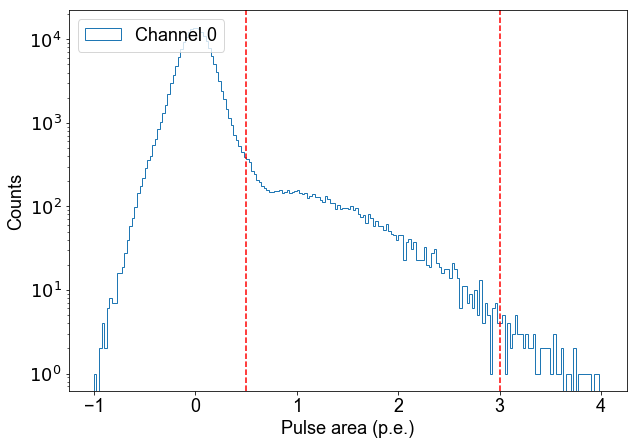

In [7]:
# Inspect the single p.e. spectrum
x.plot_area_spectrum(channel, area_bounds = area_cut_bounds, bins=200, histtype='step', label = 'Channel %d' % channel,
                    range=(-1, 4))
plt.legend()
plt.show()

In [8]:
x.cut_area(channel, area_cut_bounds)

Selected 18974 of 1012096 events (1.87 %)


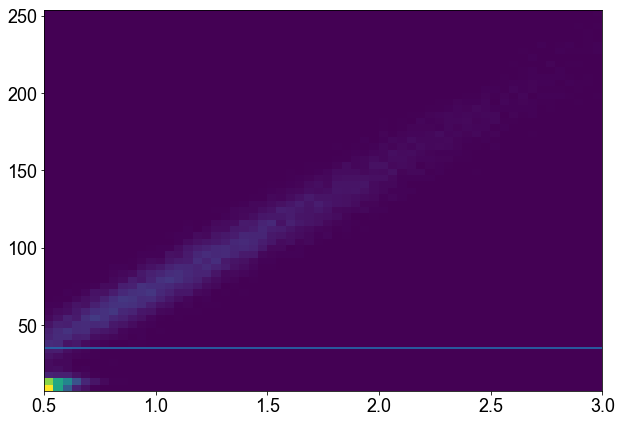

In [9]:
plt.hist2d(x.d['area_%d' % channel], x.d['max_%d' % channel], bins=60)
plt.axhline(min_amplitude)
plt.show()

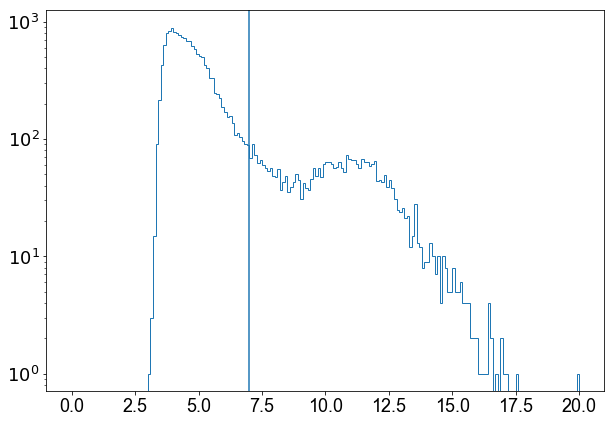

In [10]:
plt.hist(x.d['noise_%d' % channel], bins=200, histtype='step', range=(0, 20))
plt.axvline(noise_max)
plt.yscale('log')
plt.show()

In [11]:
x.cut_max(channel, (min_amplitude, 10000))

Selected 15816 of 18974 events (83.36 %)


In [12]:
x.cut_noise(channel, noise_max)

Selected 14607 of 15816 events (92.36 %)


In [13]:
# To inspect waveforms...
# for i in range(100):
#     x.plot_waveform(0, i)
#     plt.axhline(0, color='black')
#     for _l in area_bounds:
#         plt.axvline(_l * 2)
#     plt.savefig('plots/%d.png' % i)
#     plt.close()

In [14]:
time, pulse = x.get_average_pulse(channel, normalize=True, align_on='max_index', alignment_bin=340)

(-100, 400)

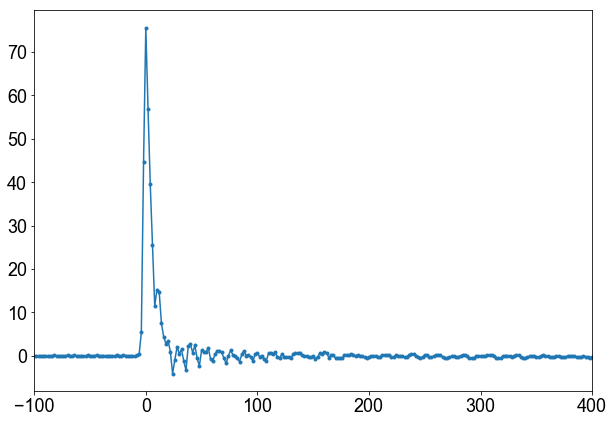

In [15]:
plt.plot(time - 340 * 2, pulse, marker='.')
plt.xlim(-100, 400)

(-5, 5)

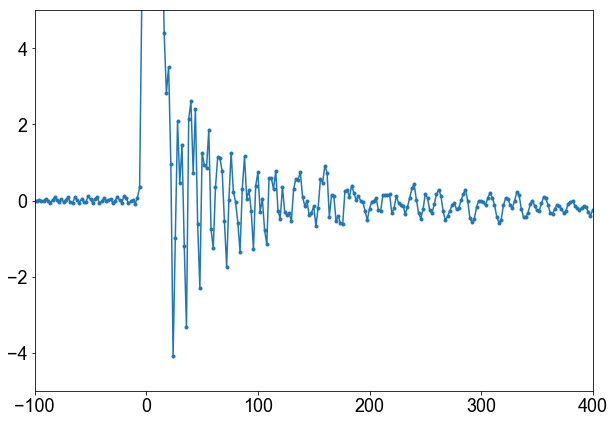

In [16]:
plt.plot(time - 340 * 2, pulse, marker='.')
plt.xlim(-100, 400)
plt.ylim(-5, 5)

In [17]:
pickle.dump(pulse, open('%s_ch%d.pickle' % (dset, channel) , 'wb'))

### Area scan

Selected 2876 of 15643 events (18.4 %)
Selected 3270 of 15643 events (20.9 %)
Selected 2970 of 15643 events (19.0 %)
Selected 2348 of 15643 events (15.0 %)
Selected 1668 of 15643 events (10.7 %)
Selected 1142 of 15643 events (7.3 %)
Selected 665 of 15643 events (4.3 %)
Selected 381 of 15643 events (2.4 %)
Selected 210 of 15643 events (1.3 %)
Selected 113 of 15643 events (0.7 %)


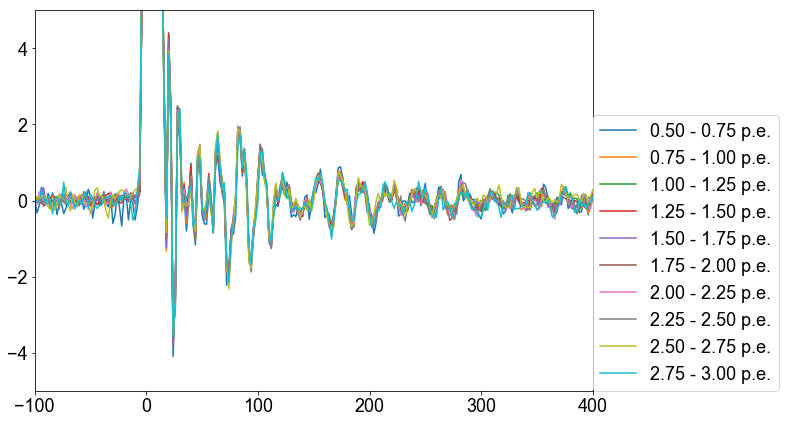

In [26]:
nbins = 11
area_bin_edges = np.linspace(*area_cut_bounds, num=nbins)
for area_min, area_max in zip(area_bin_edges[:-1], area_bin_edges[1:]):
    _x = deepcopy(x)
    _x.cut_area(channel, (area_min, area_max))
    _time, _pulse = _x.get_average_pulse(0, normalize=True, align_on='max_index', alignment_bin=340)
    plt.plot(_time - 340 * 2, _pulse, label='%.2f - %.2f p.e.' % (area_min, area_max))
plt.legend(loc=(1,0))
plt.xlim(-100, 400)
plt.ylim(-5, 5)
plt.show()

### Channel 1 (PMT1)

### To check out:

  * Per dataset
  * For different area slices (Looks good!)
  * Jackknife?
  * FFT